<a href="https://colab.research.google.com/github/stianteien/instradag/blob/master/smadaytrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import math
import numpy as np
import re
import statistics


In [2]:
def moderate_data(filnavn):
  equinor = pd.read_excel(io.BytesIO(uploaded[filnavn]))
  equinor = equinor.rename(columns={equinor.columns[0]: "tid"})
  #print(equinor)

  # Sjekker hvilke data som må fjernes
  count=0
  this_day = equinor['tid'].iloc[0].day
  for i in equinor['tid']:
    if i.day == this_day:
      count += 1
  #print(count)


  # For å gjøre det mer ekte sletter vi første 5000
  equinor = equinor[:count]
  equinor = equinor[5:]

  # Flipper opp ned
  equinor = equinor.iloc[::-1]

  #print(equinor['tid'])


  # Lager en verdi per minutt
  dataframe = equinor.copy()
  tider_m_volum = {}

  for i in range(len(dataframe['tid'])):
    if(dataframe['tid'].iloc[i].strftime("%H:%M") not in tider_m_volum):
      tider_m_volum[dataframe['tid'].iloc[i].strftime("%H:%M")] = dataframe['Volum'].iloc[i]
    else:
      tider_m_volum[dataframe['tid'].iloc[i].strftime("%H:%M")] += dataframe['Volum'].iloc[i]
    dataframe['tid'].iloc[i] = dataframe['tid'].iloc[i].strftime("%H:%M")


  dataframe = dataframe.drop_duplicates(subset="tid")

  for i in range(len(dataframe['Volum'])):
    dataframe['Volum'].iloc[i] =  tider_m_volum[dataframe['tid'].iloc[i]]

  #Plot it
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator())
  plt.plot(dataframe['tid'], dataframe['Pris'])
  plt.title(filnavn)
  plt.show()

  return dataframe


In [3]:
def make_sma(dataframe, lengde=20):

  sma = pd.DataFrame(columns=['tid', 'snitt'])
  tider = [i for i in dataframe['tid']]
  snitter = [None]*lengde
  snitt_dager = [None]*lengde
  for i in range(lengde, len(dataframe)):

    if(None in snitt_dager):
      # Startproblem
      snitt = 0
      for j in range(lengde): 
        snitt += (dataframe[dataframe['tid'] == tider[i-j]]['Pris'].item())      
      snitter.append(snitt/lengde)
      del snitt_dager[0]   # Fjern første (first in)
      snitt_dager.append(dataframe[dataframe['tid'] == tider[i]]['Pris'].item())

    else:        
      del snitt_dager[0]   # Fjern første (first in)
      snitt_dager.append(dataframe[dataframe['tid'] == tider[i]]['Pris'].item())
      snitter.append(sum(filter(None, snitt_dager))/lengde)

  sma['tid'] = tider
  sma['snitt'] = snitter
  return sma


In [4]:
def make_rsi(dataframe, lengde=20):

 rsi_verdier = pd.DataFrame(columns=['tid', 'verdi', 'snitt'])
 rsi_verdier['tid'] = [i for i in dataframe['tid']]
 verdier = []
 
 for i in range(len(dataframe)):
   
  if i > lengde:
    ups = []
    downs = []
    for j in range(lengde):
      diff = dataframe['Pris'].iloc[i-lengde+j] - dataframe['Pris'].iloc[i-lengde+j-1] # nå - forrige
      if(diff > 0):  
        ups.append(abs(diff))
      else:
        downs.append(abs(diff))
        
        
    
    downs = sum(downs)/lengde
    ups = sum(ups)/lengde
    rs = ups/downs
    rsi = 100 - 100/(1+rs)
    verdier.append(rsi)
  else:
    verdier.append(50)

 rsi_verdier['verdi'] = verdier

 snitt = []
 for i in range(len(rsi_verdier)):
  if(i>=5):
    verdier = rsi_verdier['verdi'].iloc[i-5:i+1]
    snitt.append(sum(verdier)/len(verdier))
  else:
    verdier = rsi_verdier['verdi'].iloc[0:i+1]
    snitt.append(sum(verdier)/len(verdier))

 rsi_verdier['snitt'] = snitt
  

 

 #figure(figsize=(18,6))
 #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
 #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
 #plt.plot(rsi_verdier['tid'], rsi_verdier['verdi'])
 #plt.plot(rsi_verdier['tid'], rsi_verdier['snitt'])
 #plt.plot(rsi_verdier['tid'], [30 for i in range(len(rsi_verdier))], ':', color='grey')
 #plt.plot(rsi_verdier['tid'], [75 for i in range(len(rsi_verdier))], ':', color='grey')
 #plt.plot(rsi_verdier['tid'], [80 for i in range(len(rsi_verdier))], '--', color='grey')
 #plt.title('RSI')
 return rsi_verdier

  


In [5]:
def make_bollinger_band(dataframe, sma, lengde=20):
  bollinger = pd.DataFrame(columns=['tid', 'SE_upper', 'SE_downer', 'forhold', 'snitt'])
  bollinger['tid'] = [i for i in dataframe['tid']]
  SE = []   
  SE_upper = []
  SE_downer = []
  pris = []
 
  for i in range(len(bollinger)):
    if(i>lengde):
      x = [dataframe['Pris'].iloc[i-lengde+j] for j in range(lengde)]
      mean_x = sum(x)/len(x)
      SE.append(math.sqrt(sum([(j-mean_x)**2 for j in x])/(lengde-1)))

      SE_upper.append(sma['snitt'].iloc[i] + SE[i]*2)
      SE_downer.append(sma['snitt'].iloc[i] - SE[i]*2)
      pris.append(dataframe['Pris'].iloc[i])
    else:
      SE.append(None)
      SE_upper.append(SE[i])
      SE_downer.append(SE[i])


  bollinger['SE_upper'] = SE_upper
  bollinger['SE_downer'] = SE_downer
  bollinger['forhold'] = bollinger['SE_upper']/bollinger['SE_downer']

  snitt = []
  for i in range(len(bollinger)):
    if(i>lengde+1):
      if(len(snitt) > 60+lengde):
        snitt.append(sum(bollinger['forhold'].iloc[i-60:i])/len(bollinger['forhold'].iloc[i-60:i]))
      else:
        snitt.append(sum(bollinger['forhold'].iloc[lengde+1:i])/len(bollinger['forhold'].iloc[lengde+1:i]))

    else:
      snitt.append(None)
  bollinger['snitt'] = snitt
 

  #figure(figsize=(18,6))
  #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  #plt.gca().xaxis.set_major_locator(mdates.DayLocator())

  #plt.plot(bollinger['tid'], [1.015 for i in range(len(bollinger))], ':', color='white')
  #plt.plot(bollinger['tid'], bollinger['forhold'])
  #plt.plot(bollinger['tid'], bollinger['forhold'] + math.sqrt(sum(bollinger['forhold']-bollinger['snitt'])**2/(1-len(bollinger))))
  #plt.plot(bollinger['tid'], bollinger['snitt'], ':', color='grey')
  #plt.title('Bollinger band forhold')
  
  return bollinger





In [6]:
def make_derivert(dataframe, sma, lengde):
  derivert = pd.DataFrame(columns=['tid', 'verdi', 'snitt'])
  derivert['tid'] = [i for i in dataframe['tid']]

  verdi = []
  snitt = []
  for i in range(len(derivert)):
    if(not math.isnan(sma['snitt'].iloc[i-1]) and not math.isnan(sma['snitt'].iloc[i])):
      verdi.append(sma['snitt'].iloc[i] - sma['snitt'].iloc[i-1])
    else:
      verdi.append(None)

  derivert['verdi'] = verdi

  for i in range(len(derivert)):
    if(i>lengde+1):
      if(len(snitt) > 60+lengde):
        snitt.append(sum(derivert['verdi'].iloc[i-60:i])/len(derivert['verdi'].iloc[i-60:i]))
      else:
        snitt.append(sum(derivert['verdi'].iloc[lengde+1:i])/len(derivert['verdi'].iloc[lengde+1:i]))

    else:
      snitt.append(None)

  derivert['snitt'] = snitt

  #figure(figsize=(18,6))
  #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  #plt.gca().xaxis.set_major_locator(mdates.DayLocator())

  #plt.plot(derivert['tid'], [0 for i in range(len(derivert))], '--', color='grey')
  #plt.plot(derivert['tid'], derivert['verdi'])
  #plt.plot(derivert['tid'], derivert['snitt'], ':', color='grey')
  #plt.title('Derivert')

  return derivert
  
  


In [17]:
def make_adx(dataframe, sma, lengde=20):
  #positiv DMI
  posDI = [0]
  negDI = [0]
  for i in range(1, len(dataframe)):
    direction = dataframe['Pris'].iloc[i] - dataframe['Pris'].iloc[i-1]  # Positiv er opp, negativ er ned
    if(direction > 0):
      posDI.append(direction)
      negDI.append(0)
    else:
      posDI.append(0)
      negDI.append(direction)

    
  PDM = [0]*lengde
  for i in range(len(sma)):
    if i > lengde:
      PDM.append(posDI[i-lengde:i])



  #figure(figsize=(18,6))
  #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  #plt.gca().xaxis.set_major_locator(mdates.DayLocator())

  #plt.plot(dataframe['tid'], posDI)

    
  #PDM = [PDM[i-n]]
  #truerate er bare prisen delt på n (snittet av n siste priser) altså sma!

  #negativ DMI

In [8]:
def handel_status(model_mean, model_std, sma1, sma2, sma3, trend, rsi, bollinger, derivert, dataframe):
  maxen = dataframe['Pris'].max()
  minen = dataframe['Pris'].min()
  aswitch = False
  fallswitch = False
  status = []
  sma_score = []
  rsi_snitt = []
  kjøps_pris = 0
  kjøp_inne = False
  utvikling = [0]*30
  ak_ut = [0]*30
  start_informasjon = pd.DataFrame(columns=['tid', 'indeks', 'endeks', 'Pris', 'score'])
  start_skudd = True
  model_score = 0
  model_i = 5
  høyest_pris = 0
  fall = 10

  for i in range(len(trend)):
    if(not math.isnan(trend['snitt'].iloc[i])):
    
      # Siste 10 min er bedre enn siste 20 min?
      siste_10min = dataframe['Pris'].iloc[i-5:i+1]
      siste_20min = dataframe['Pris'].iloc[i-20:i+1]
      utvik = sum(siste_10min)/len(siste_10min) - sum(siste_20min)/len(siste_20min)
      utvikling.append(utvik)
      if((utvik)>0):
        ak_ut.append(ak_ut[-1] + math.sqrt(math.sqrt(utvik)))
        if(start_skudd):
          start_informasjon = start_informasjon.append({'tid':dataframe['tid'].iloc[i],'indeks':i, 'endeks':0, 'Pris':dataframe['Pris'].iloc[i], 'score':0}, ignore_index=True)
          start_skudd = False
      else:
        ak_ut.append(0)
        if(not start_skudd):
          start_skudd = True
          start_informasjon['score'].iloc[len(start_informasjon)-1] = ak_ut[-2]
          start_informasjon['endeks'].iloc[len(start_informasjon)-1] = i-1

      # Prosent igjen til å nå bollingertoppen
      span = bollinger['SE_upper'].iloc[i] - bollinger['SE_downer'].iloc[i]
      fra_toppen = (bollinger['SE_upper'].iloc[i] - dataframe['Pris'].iloc[i])/span
     
      # Score innenfor modellen
      if (model_mean is not None):
        model_breakpoint = 20
        model_starter = 5
        indikator = {'derivert':0, 'RSI':0, 'bollinger_forhold':0, 'sma':0, 'sma_derivert':0, 'bollinger_topp':0}
        for j in indikator.keys():
          indikator[j] = (model_mean[j][model_i] - model_std[j][model_i]*2, model_mean[j][model_i] + model_std[j][model_i]*2)
      
        sma_derivert = (sma3['snitt'].iloc[i] - sma3['snitt'].iloc[i-1]) 
        + (sma1['snitt'].iloc[i] - sma1['snitt'].iloc[i-1])
        + (trend['snitt'].iloc[i] - trend['snitt'].iloc[i-1])


        RSI_indikator = indikator['RSI'][0] < rsi['snitt'].iloc[i] < indikator['RSI'][1]
        derivert_indikator = indikator['derivert'][0] < derivert['verdi'].iloc[i] < indikator['derivert'][1]
        sma_indikator = indikator['sma'][0] < sma1['snitt'].iloc[i] - trend['snitt'].iloc[i] < indikator['sma'][1]
        sma_d_indikator = indikator['sma_derivert'][0] < sma_derivert < indikator['sma_derivert'][1]
        bollinger_f_indikator = indikator['bollinger_forhold'][0] < bollinger['forhold'].iloc[i] < indikator['bollinger_forhold'][1]
        bollinger_t_indikator = indikator['bollinger_topp'][0] < fra_toppen < indikator['bollinger_topp'][1]


        if(RSI_indikator and sma_indikator):
          model_score += 1
          model_i += 1
          if(model_i == len(model_mean['RSI'])):
            model_i -= 1
        else:
          model_score = 0
          model_i = model_starter

      

      

      # Trend
      trendvei = trend['snitt'].iloc[i] - trend['snitt'].iloc[i-1]  # >0 opp, <0 ned
      kort_trendvei = sma3['snitt'].iloc[i] - sma3['snitt'].iloc[i-1]
      

      if(sma2['snitt'].iloc[i] < sma1['snitt'].iloc[i]):
        aswitch = True

      # høyest pris etter kjøp
      if(kjøp_inne):
        if dataframe['Pris'].iloc[i] > høyest_pris:
          høyest_pris = dataframe['Pris'].iloc[i]
        fall = dataframe['Pris'].iloc[i] / høyest_pris
      

      if(model_score > 20
         and trendvei > 0
         and kort_trendvei > 0
          #sma1['snitt'].iloc[i] < dataframe['Pris'].iloc[i] 
           #and aswitch 
           #rsi['snitt'].iloc[i] < 30
           #and bollinger['forhold'].iloc[i] > bollinger['snitt'].iloc[i] # Funker dette egentlig?
           #and rsi['snitt'].iloc[i] > rsi['snitt'].iloc[i-1]
           #and sma3['snitt'].iloc[i] > sma3['snitt'].iloc[i-1]
           #and sma1['snitt'].iloc[i] < dataframe['Pris'].iloc[i] 
           #and rsi_5 > rsi['verdi'].iloc[i]
           #and fra_toppen > 0.15
           #and derivert['verdi'].iloc[i] > 1.0001 
           #and derivert['verdi'].iloc[i] > derivert['snitt'].iloc[i]
           ): #Kjøp
        print(model_score)
        status.append(maxen)
        if(not kjøp_inne):
          
          kjøp_inne = True
          kjøps_pris = dataframe['Pris'].iloc[i]

      elif(fall < 0.997 or dataframe['Pris'].iloc[i] < kjøps_pris*0.9999
           or (trendvei < 0 and
            (sma2['snitt'].iloc[i] > sma3['snitt'].iloc[i] 
            or rsi['snitt'].iloc[i] > 80))
           ): #Selg
        if(kjøp_inne):
          model_score = 0
          høyest_pris = 0
          fall = 10
          print(dataframe['Pris'].iloc[i] < kjøps_pris*98, 'Pris under 0.1% av kjøpspris', dataframe['Pris'].iloc[i], kjøps_pris*0.98)
          print(trendvei < 0, 'Trend på vei ned')
          print(sma2['snitt'].iloc[i] > sma3['snitt'].iloc[i], 'sma liten under sma middels')
          print(rsi['snitt'].iloc[i] > 80, 'rsi over 80')
          print('-----')

        status.append(minen)
        aswitch = False
        fallswitch = False
        kjøp_inne = False
        
      else:
        status.append(status[-1])

      
    else:
      status.append(minen)



  # Jobb med dataframe for startverdier i ak_ut, lag en multiindex
  start_df = pd.DataFrame(columns=['tid', 'indeks', 'endeks', 'Pris', 'score', 'derivert', 'RSI', 'bollinger_forhold', 'sma', 'sma_derivert', 'bollinger_topp'])
  for i in range(len(start_informasjon)):
    if(start_informasjon['score'].iloc[i] > 25 and start_informasjon['endeks'].iloc[i] - start_informasjon['indeks'].iloc[i] > 25):
       indeksen = start_informasjon['indeks'].iloc[i]
       endeksen = start_informasjon['endeks'].iloc[i]
       lengde = endeksen - indeksen

       rsi_ = [rsi['snitt'].iloc[j] for j in range(indeksen, endeksen)]
       derivert_ = [derivert['verdi'].iloc[j] for j in range(indeksen, endeksen)]
       bollinger_ = [bollinger['forhold'].iloc[j] for j in range(indeksen, endeksen)]
       sma_ =[sma1['snitt'].iloc[j] - trend['snitt'].iloc[j] for j in range(indeksen, endeksen)]
       sma_derivert = [(sma3['snitt'].iloc[j] - sma3['snitt'].iloc[j-1])
                       + (sma1['snitt'].iloc[j] - sma1['snitt'].iloc[j-1])
                       + (trend['snitt'].iloc[j] - trend['snitt'].iloc[j-1])
                       for j in range(indeksen, endeksen)]
       
       # Prosent igjen til å nå bollingertoppen
       #span = (bollinger['SE_upper'].iloc[i] - bollinger['SE_downer'].iloc[i])
       fra_toppen = [(bollinger['SE_upper'].iloc[j] - dataframe['Pris'].iloc[j])/(bollinger['SE_upper'].iloc[j] - bollinger['SE_downer'].iloc[j]) for j in range(indeksen, endeksen)]

       print(len(sma_), len(fra_toppen))
       
       start_df = start_df.append({'tid':start_informasjon['tid'].iloc[i],
                                   'indeks':start_informasjon['indeks'].iloc[i],
                                   'endeks':start_informasjon['endeks'].iloc[i], 
                                   'Pris':start_informasjon['Pris'].iloc[i],
                                   'score':start_informasjon['score'].iloc[i],
                                   'derivert': derivert_,
                                   'RSI':rsi_,
                                   'bollinger_forhold':bollinger_,
                                   'sma': sma_,
                                   'sma_derivert': sma_derivert,
                                   'bollinger_topp': fra_toppen
                                   },
                                   ignore_index=True)

  #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  #  print(start_df)


  #print((status))
  #figure(figsize=(18,6))
  #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
  #plt.plot([i for i in dataframe['tid']], utvikling)
  #plt.plot([i for i in dataframe['tid']], [0 for i in range(len(dataframe))], ':', color='grey')
  #plt.title('Utvikling forhold')
  #plt.show()
  figure(figsize=(18,6))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator())
  plt.plot([i for i in dataframe['tid']], ak_ut)
  plt.title('Utvikling positiv akumulert')
  plt.show()
  
  
  print('----------FERDIG---------')
  return status, start_df


def handels_utførelse(status, dataframe):
  #status = status_input[0]
  maxen = dataframe['Pris'].max()
  minen = dataframe['Pris'].min()
  kjøp_og_selg = []
  mymoney = minen
  for i in range(len(status)):
    if status[i] != mymoney and status[i] != None:
      # Kjøp go selg
      mymoney = status[i]
      kjøp_og_selg.append(i)

    if(mymoney == maxen and i == len(status)-1):
      kjøp_og_selg.append(i)

  return kjøp_og_selg

In [9]:
def printing(smas, navn, status, dataframe, bollinger_band, title="title"):
  figure(figsize=(18,6))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator())
  plt.plot(dataframe['tid'], dataframe['Pris'], label='Prisen')
  for i in range(len(smas)):

    plt.plot(smas[i]['tid'], smas[i]['snitt'], label = navn[i])
    #plt.plot(sma6['tid'], sma6['snitt'], color='orange', label = 'SmaHandel_minutt')

  plt.plot(range(len(status)), status, color='grey', linewidth=0.5, label='Opp-kjøp, Ned-selg')
  plt.plot(bollinger_band['tid'], bollinger_band['SE_upper'], color='violet', linewidth=0.5)
  plt.plot(bollinger_band['tid'], bollinger_band['SE_downer'], color='violet', linewidth=0.5)
  #plt.ylim(bottom=200)
  #plt.plot(dataframe['tid'][50:52], [125, 130])
  plt.legend()
  plt.title(title)
  plt.show()
  #print(type(bollinger_band['SE_downer']), type( dataframe['Pris']))


  #plt.show()

In [10]:
def simulering(kjøp_og_selg, dataframe, print_handel=False): 
  start_money = 2500
  for i in range(0,len(kjøp_og_selg),2):

    fortjenest = (dataframe['Pris'].iloc[kjøp_og_selg[i+1]]/dataframe['Pris'].iloc[kjøp_og_selg[i]])
    start_money = start_money*fortjenest - 2

    if(print_handel):
      print('kjøp:',dataframe['Pris'].iloc[kjøp_og_selg[i]],
            'selg:',dataframe['Pris'].iloc[kjøp_og_selg[i+1]],
            'tjent i prosent:',round((fortjenest-1)*100 ,2),'%')

  #print(start_money)
  if(print_handel):
    print('Antall handler:', len(kjøp_og_selg))

  return start_money, len(kjøp_og_selg)


In [11]:

def multi_sim(the_range, dataframe):
  sma_range = the_range# range(3,41)
  antall = 0
  best_model = None
  best_score = 0
  all_scores = []
  all_sma = {}
  o=0
  for i in sma_range:

    if(i not in all_sma):
      all_sma[i] = make_sma(dataframe, i)

    for j in range(sma_range[0],i):
      #all_sma[j] = make_sma(dataframe, j)

      #for o in range(sma_range[0],j):
        
        #print(all_sma.keys(), i, j, o)
      sma_kontroll = all_sma[i] # alltid høyest
      sma_handel = all_sma[j]   # alltid midten
      sma_minstehandel = all_sma[j] #alltid minst
      
        # kjør simulering
        # lagre verdier
      kjøp_og_selg_sma = handels_utførelse(handel_status(sma_kontroll, sma_handel, sma_minstehandel, dataframe), dataframe)
      results = simulering(kjøp_og_selg_sma[0], dataframe)
      antall += 1

      all_scores.append([i, j, o, results[0]])
      if(results[0] > best_score):
        best_score = results[0]
        best_model = (i, j, o)
      
      #print(i,j,'this score:', results[0],'\tbest:',best_score,'with',best_model,'\tAntall handler:',results[1])

  print(best_score, best_model, 'antall sim:',antall)
  return all_scores



In [12]:
def tredprinting(x,y,z):
  from mpl_toolkits.mplot3d import Axes3D
  from matplotlib import cm
  #from matplotlib import colormap


  fig = plt.figure(figsize=(10,7))
  ax = fig.gca(projection='3d')

  x_surface, y_surface = np.meshgrid(x,y)
  z_surface = 1000*np.ones((len(x_surface), len(y_surface)))
  
  #y_surface
  #print(x_surface)

  #im2 = ax.plot_surface(x_surface, y_surface, z_surface, cmap='Greys')
  im = ax.scatter(x, y, z, c=z, cmap='jet')
  
  fig.colorbar(im, ax=ax, fraction=0.15, pad=0.01)

  ax.set_xlabel('sma_1_høy')
  ax.set_ylabel('sma_2_lav')
  ax.set_zlabel('Money')
  #ax.enable_move = True

  plt.show()


In [13]:

def print_scatter_2d(my_multisim):
  a = my_multisim
  a = sorted(a, key=lambda x:x[-1], reverse=True)
  a = (a[:20])
  a = [i for i in a if(i[-1]>2)]
  print(a)
  #[i[0] for i in a]
  plt.scatter([i[0] for i in a], [i[1] for i in a], c=[i for i in range(len(a))], cmap='hot')
  plt.plot([i for i in range(1,60)], [i for i in range(1,60)])
  plt.plot([i for i in range(1,60)], [i/2 for i in range(1,60)])
  plt.plot([i for i in range(1,60)], [i/1.333 for i in range(1,60)])
  #plt.xlim(1, 60)
  #plt.ylim(1, 60)
  plt.xlabel('høy')
  plt.ylabel('lav')
  #plt.plot([i[0] for i in a], [i[1] for i in a], )
  for i in range(len(a)):
    plt.annotate(i+1, (a[i][0], a[i][1]))
  plt.show()

Saving Aker 30.04.2020.xlsx to Aker 30.04.2020.xlsx
Saving DNO 30.04.2020.xlsx to DNO 30.04.2020.xlsx
Saving NEL 30.04.2020.xlsx to NEL 30.04.2020.xlsx
Saving Tomra Systems 30.04.2020.xlsx to Tomra Systems 30.04.2020.xlsx
Saving Orkla 30.04.2020.xlsx to Orkla 30.04.2020.xlsx
Saving Norwegian Finans Holding 30.04.2020.xlsx to Norwegian Finans Holding 30.04.2020.xlsx
Saving Telenor 30.04.2020.xlsx to Telenor 30.04.2020.xlsx
Saving Yara International 30.04.2020.xlsx to Yara International 30.04.2020.xlsx
Saving Norsk Hydro 30.04.2020.xlsx to Norsk Hydro 30.04.2020.xlsx
Saving Storebrand 30.04.2020.xlsx to Storebrand 30.04.2020.xlsx
Saving Aker BP 30.04.2020.xlsx to Aker BP 30.04.2020.xlsx
Saving Frontline 30.04.2020.xlsx to Frontline 30.04.2020.xlsx
Saving Mowi 30.04.2020.xlsx to Mowi 30.04.2020.xlsx
Saving DNB 30.04.2020.xlsx to DNB 30.04.2020.xlsx


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


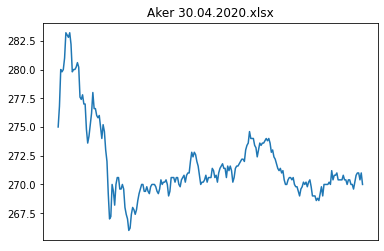

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


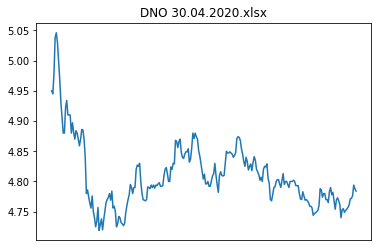

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


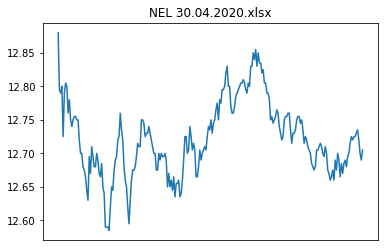

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


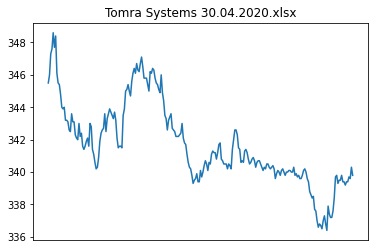

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


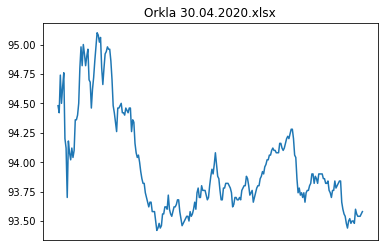

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


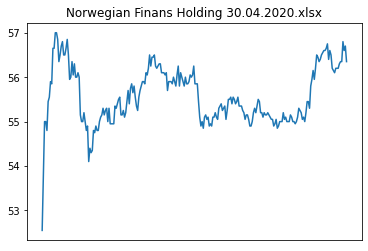

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


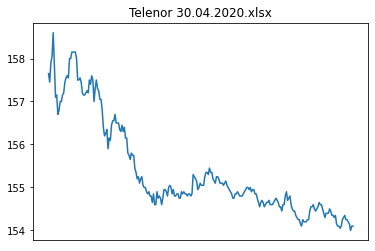

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


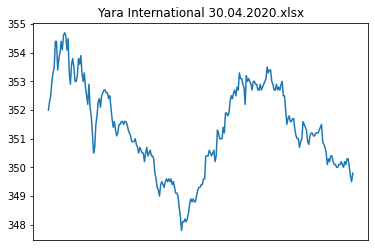

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


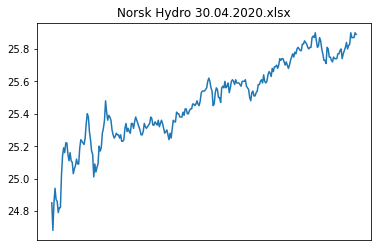

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


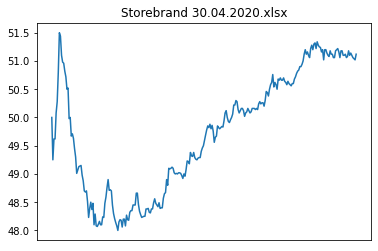

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


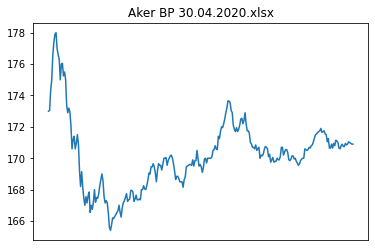

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


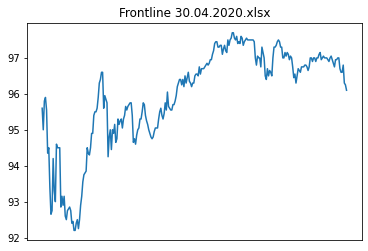

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


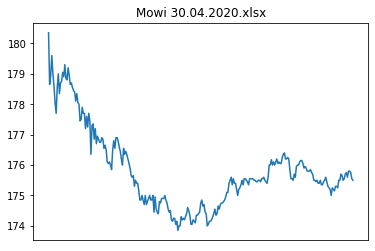

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


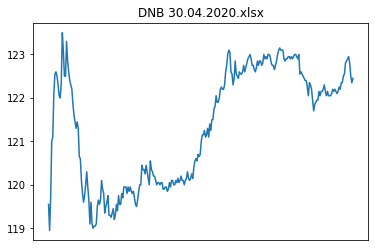

In [14]:
uploaded = files.upload()
dataframes = []

for keys in list(uploaded.keys()):
  dataframes.append(moderate_data(keys))


In [ ]:
# Arbeidsrute
topp20 = []
for data in dataframes:
  topp20.append(multi_sim(range(3, 35), data)) 
  
# 100 61 38 forhold --> 
# Mål: Analaysere mange dager, finne topp 20(?) med positivt, så ta snittet av det

In [ ]:
top20 = []
for i in topp20:
  toppen = sorted(i, key=lambda x:x[3], reverse=True)
  top20.append(toppen[:20])

print(top20[2]) #DNB


[[29, 10, 0, 10062.567303480399], [29, 8, 0, 10053.612968739862], [29, 6, 0, 10051.592083981557], [14, 10, 0, 10044.421789731674], [13, 10, 0, 10040.10043084046], [15, 4, 0, 10039.550784228526], [27, 6, 0, 10038.543931567221], [24, 8, 0, 10036.392256072875], [16, 4, 0, 10033.143636291239], [15, 6, 0, 10032.993262322945], [14, 6, 0, 10031.298214262624], [14, 7, 0, 10031.201559524665], [17, 4, 0, 10030.682833661103], [29, 5, 0, 10027.922347428474], [27, 7, 0, 10027.862160966051], [15, 10, 0, 10027.203494156618], [24, 6, 0, 10025.614692144169], [13, 8, 0, 10024.648295111625], [29, 9, 0, 10023.34999548276], [16, 10, 0, 10022.761194031335]]


In [ ]:
topz = {}
for i in top20:
  for j in i:
    for o in j:
      
      my_key = str(j[0])+','+str(j[1])+','+str(j[2])
      if my_key not in topz: 
        topz[my_key] = [j[3]]
      else:
        topz[my_key].append(j[3])

print(topz)


{'5,4,0': [10824.754014153676, 10824.754014153676, 10824.754014153676, 10824.754014153676, 10087.118389585094, 10087.118389585094, 10087.118389585094, 10087.118389585094], '6,5,0': [10772.489655587518, 10772.489655587518, 10772.489655587518, 10772.489655587518], '11,8,0': [10701.883765091025, 10701.883765091025, 10701.883765091025, 10701.883765091025, 10078.814192805628, 10078.814192805628, 10078.814192805628, 10078.814192805628], '12,9,0': [10651.725203636754, 10651.725203636754, 10651.725203636754, 10651.725203636754], '4,3,0': [10632.200430098916, 10632.200430098916, 10632.200430098916, 10632.200430098916, 10139.293755748966, 10139.293755748966, 10139.293755748966, 10139.293755748966], '12,8,0': [10623.13150415107, 10623.13150415107, 10623.13150415107, 10623.13150415107, 10250.852013668786, 10250.852013668786, 10250.852013668786, 10250.852013668786], '11,9,0': [10618.909763782403, 10618.909763782403, 10618.909763782403, 10618.909763782403], '10,8,0': [10615.670893680986, 10615.67089

In [ ]:
# Nå forsker jeg på at den mest verdifulle er den med flest ting i seg
most_freq = []
for keys in topz.keys():
  x = (keys.split(','))
  most_freq.append([int(x[0]), int(x[1]), int(x[2]), len(topz[keys])])
  #print(len(topz[keys]))

print(sorted(most_freq, key=lambda x:x[3], reverse=True))

[[13, 6, 0, 16], [14, 6, 0, 16], [11, 5, 0, 12], [13, 5, 0, 12], [12, 5, 0, 12], [16, 5, 0, 12], [14, 5, 0, 12], [15, 5, 0, 12], [12, 7, 0, 12], [14, 10, 0, 12], [15, 4, 0, 12], [16, 4, 0, 12], [15, 6, 0, 12], [15, 10, 0, 12], [16, 10, 0, 12], [13, 4, 0, 12], [12, 4, 0, 12], [18, 13, 0, 12], [16, 9, 0, 12], [5, 4, 0, 8], [11, 8, 0, 8], [4, 3, 0, 8], [12, 8, 0, 8], [13, 12, 0, 8], [15, 12, 0, 8], [15, 13, 0, 8], [19, 5, 0, 8], [13, 8, 0, 8], [19, 6, 0, 8], [29, 10, 0, 8], [13, 10, 0, 8], [24, 8, 0, 8], [14, 7, 0, 8], [17, 4, 0, 8], [31, 20, 0, 8], [34, 20, 0, 8], [34, 21, 0, 8], [34, 22, 0, 8], [34, 23, 0, 8], [34, 24, 0, 8], [34, 25, 0, 8], [31, 23, 0, 8], [31, 25, 0, 8], [32, 25, 0, 8], [32, 26, 0, 8], [17, 16, 0, 8], [24, 17, 0, 8], [14, 4, 0, 8], [11, 4, 0, 8], [17, 5, 0, 8], [15, 7, 0, 8], [12, 3, 0, 8], [13, 3, 0, 8], [33, 20, 0, 8], [30, 3, 0, 8], [24, 10, 0, 8], [17, 14, 0, 8], [17, 13, 0, 8], [18, 14, 0, 8], [19, 13, 0, 8], [14, 11, 0, 8], [15, 9, 0, 8], [16, 15, 0, 8], [6, 5, 

[[13, 6, 0, 16], [14, 6, 0, 16], [11, 5, 0, 12], [13, 5, 0, 12], [12, 5, 0, 12], [16, 5, 0, 12], [14, 5, 0, 12], [15, 5, 0, 12], [12, 7, 0, 12], [14, 10, 0, 12], [15, 4, 0, 12], [16, 4, 0, 12], [15, 6, 0, 12], [15, 10, 0, 12], [16, 10, 0, 12], [13, 4, 0, 12], [12, 4, 0, 12], [18, 13, 0, 12], [16, 9, 0, 12], [5, 4, 0, 8]]


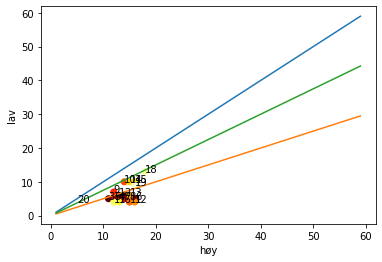

In [ ]:
print_scatter_2d(most_freq)

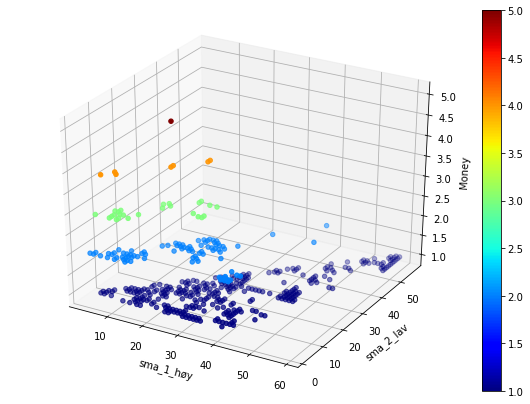

DNB ræva dag


In [ ]:
tredprinting([i[0] for i in most_freq], [i[1] for i in most_freq], [i[2] for i in most_freq])
print("DNB ræva dag")

Equinor - Opp og ned


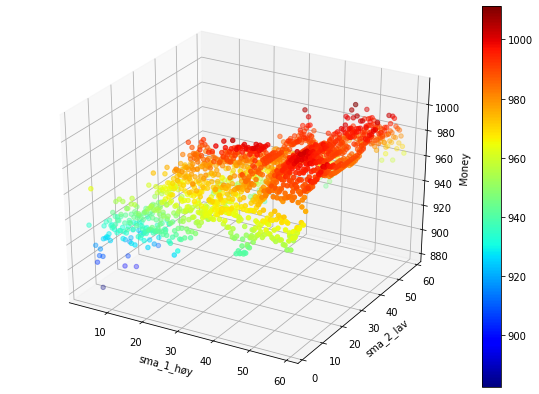

In [ ]:
print("Equinor - Opp og ned")
tredprinting(my_multisim[0], my_multisim[1], my_multisim[2])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


47 47


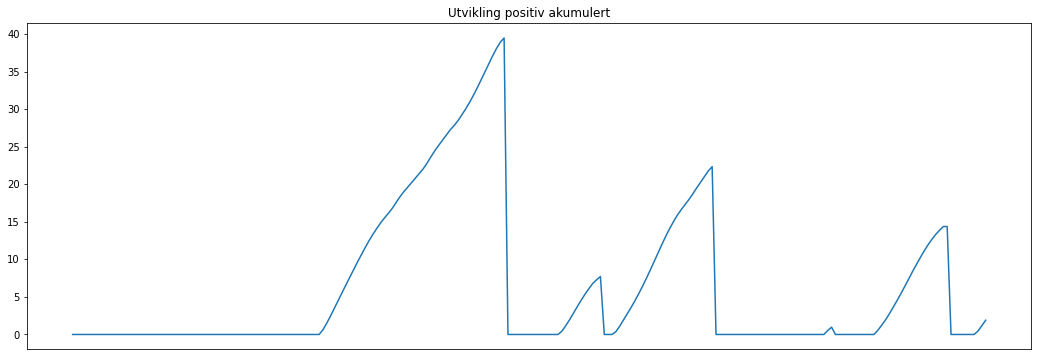

----------FERDIG---------


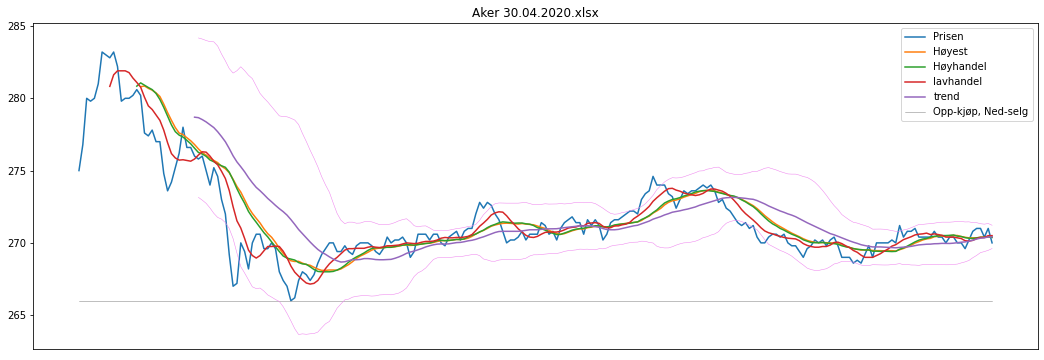

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


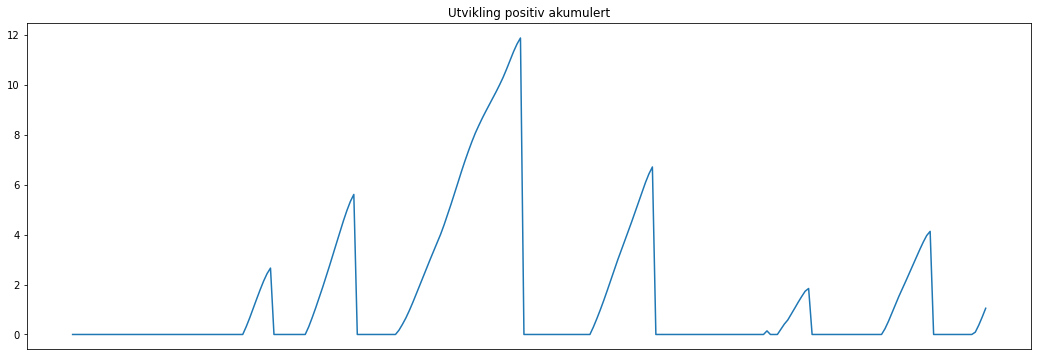

----------FERDIG---------


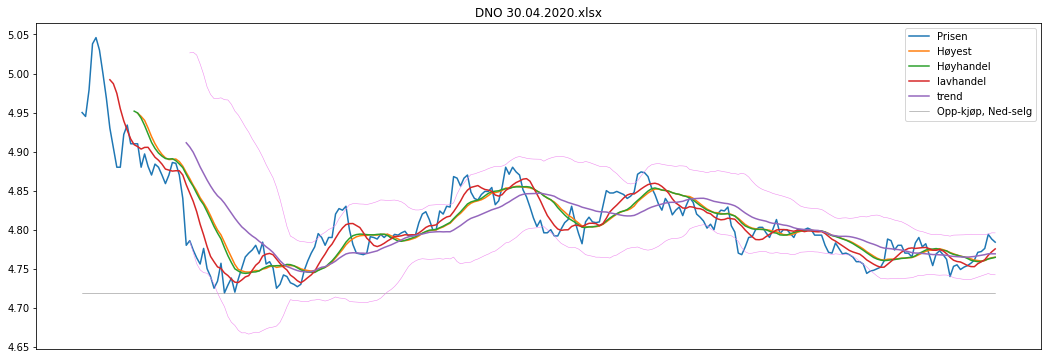

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


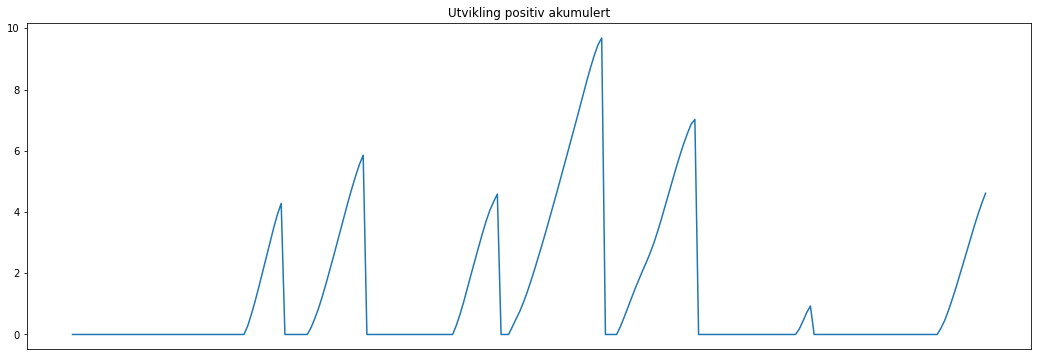

----------FERDIG---------


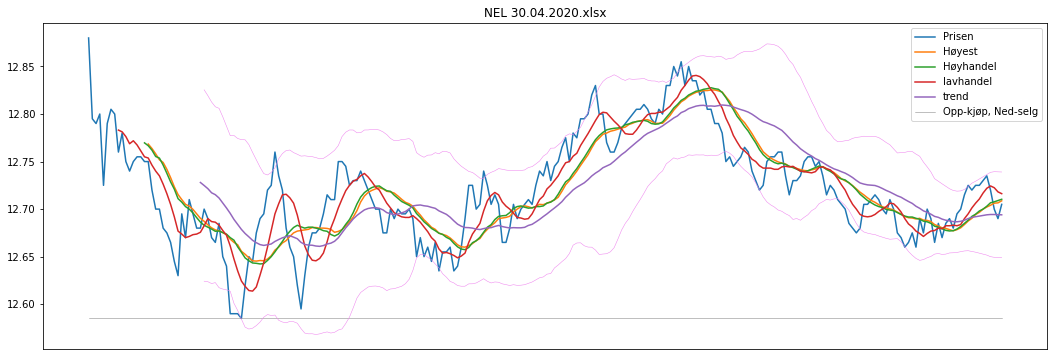

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


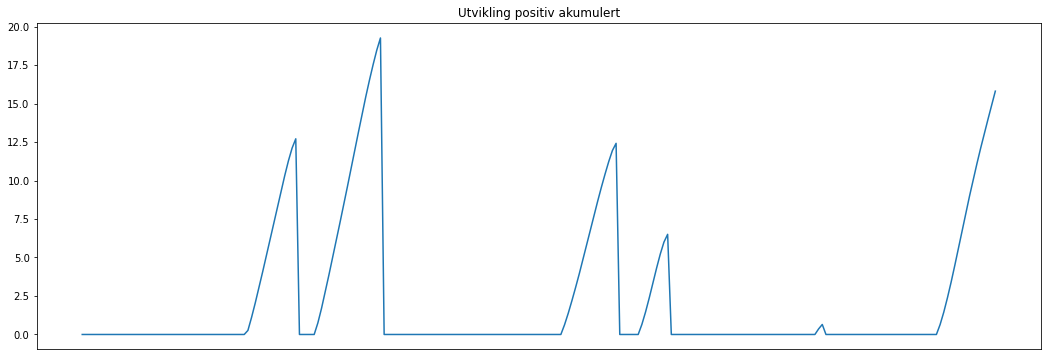

----------FERDIG---------


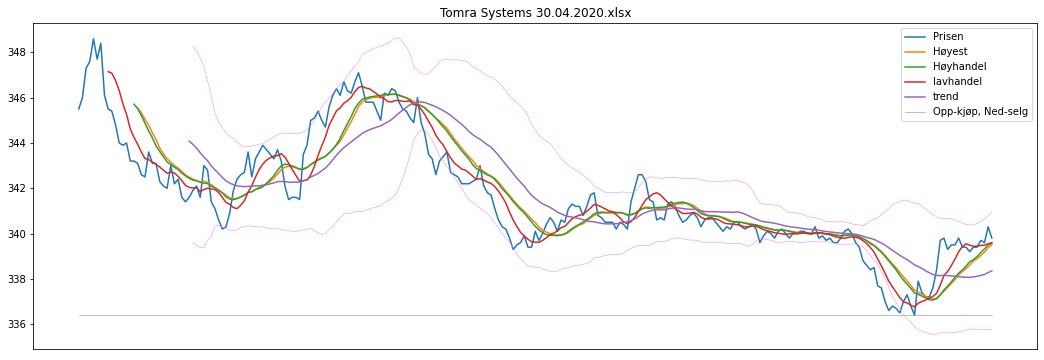

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


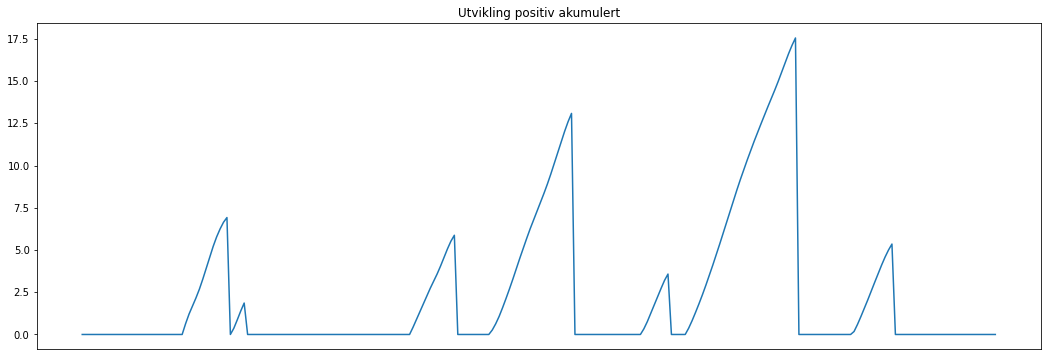

----------FERDIG---------


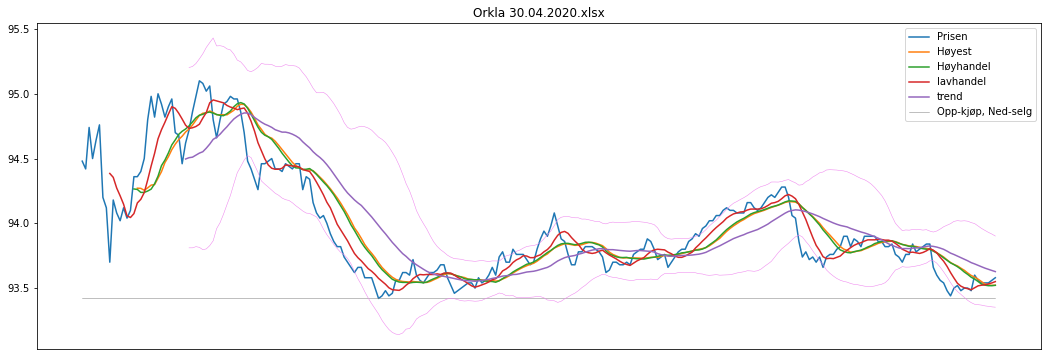

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


52 52
39 39


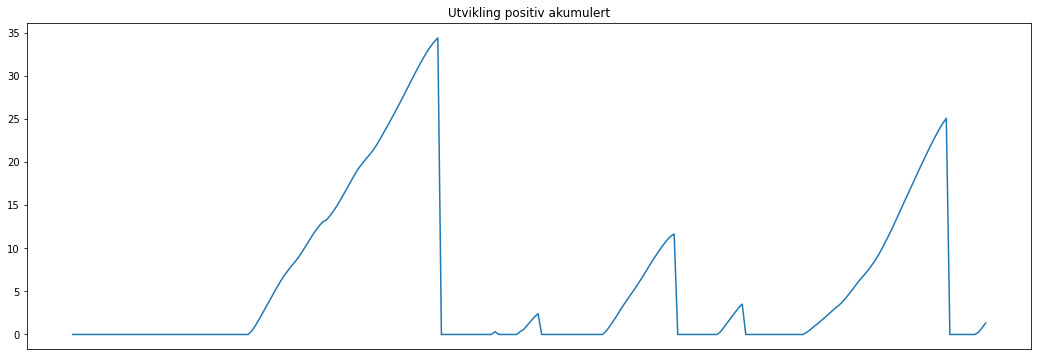

----------FERDIG---------


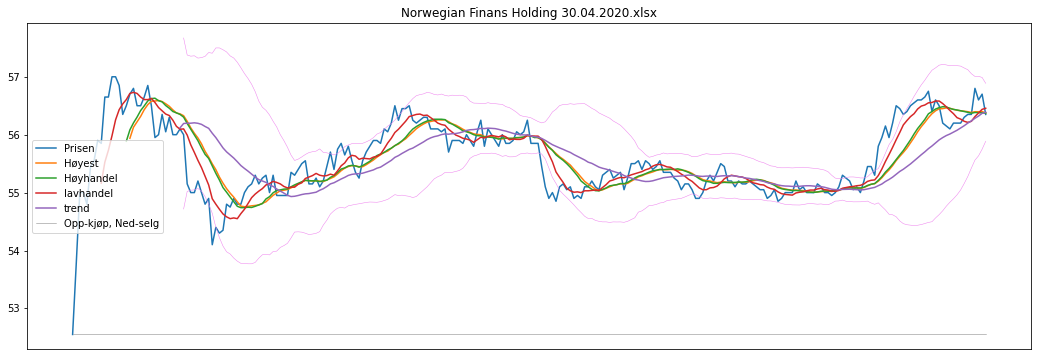

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


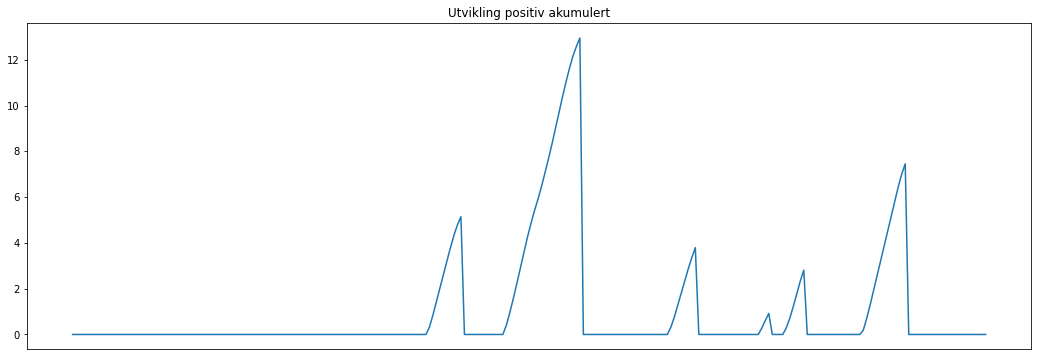

----------FERDIG---------


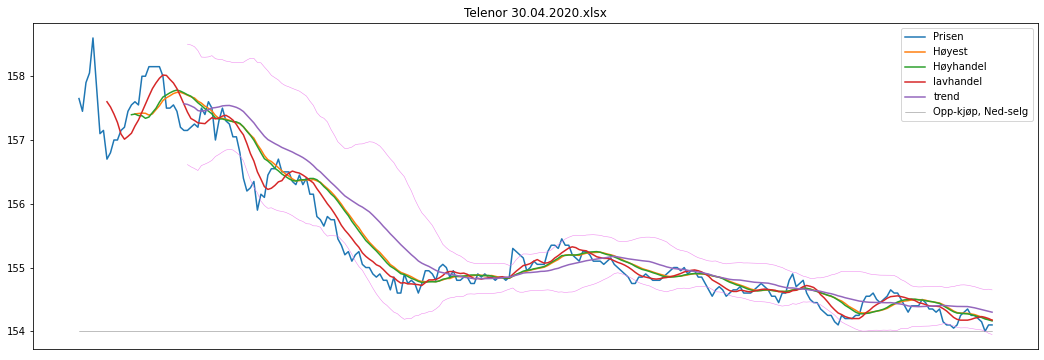

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


54 54


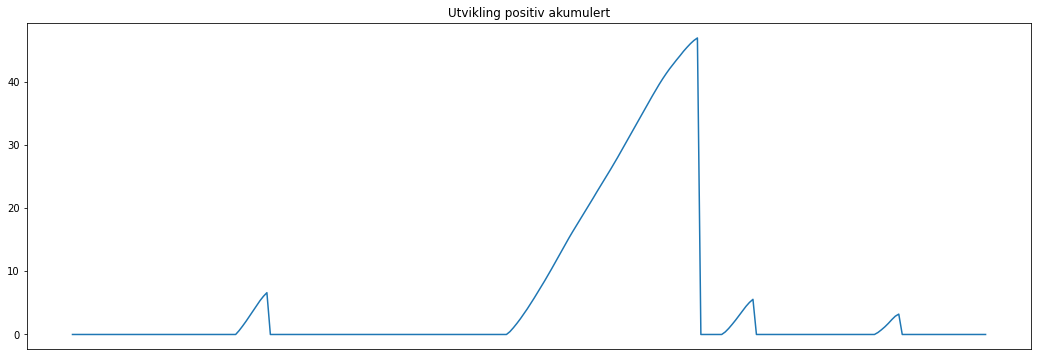

----------FERDIG---------


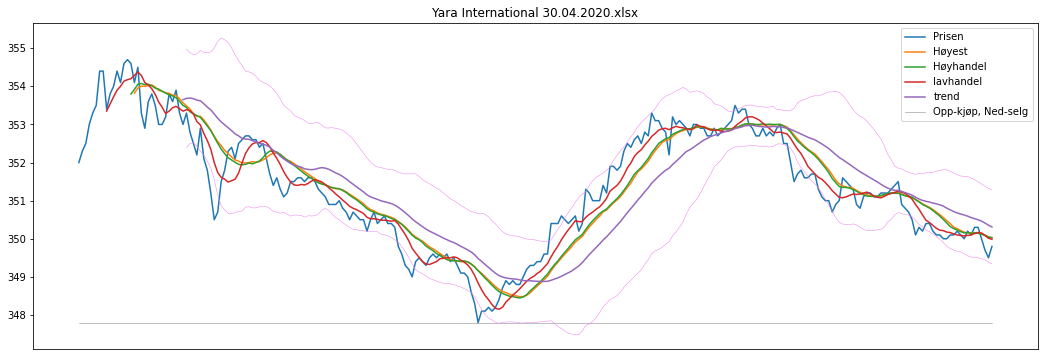

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


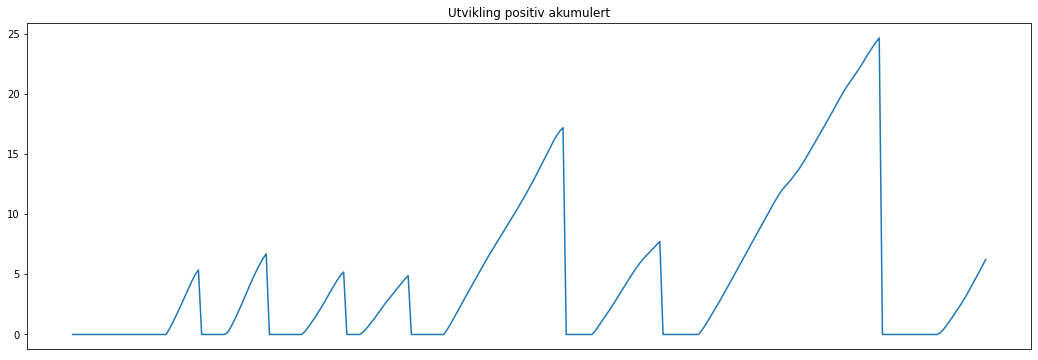

----------FERDIG---------


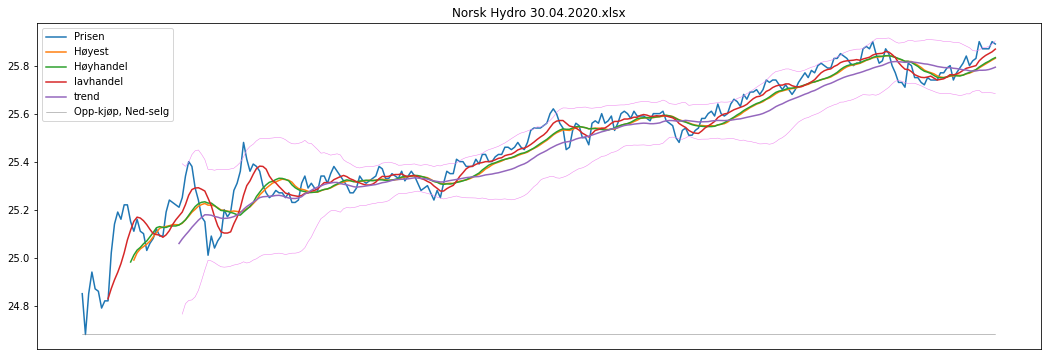

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


86 86


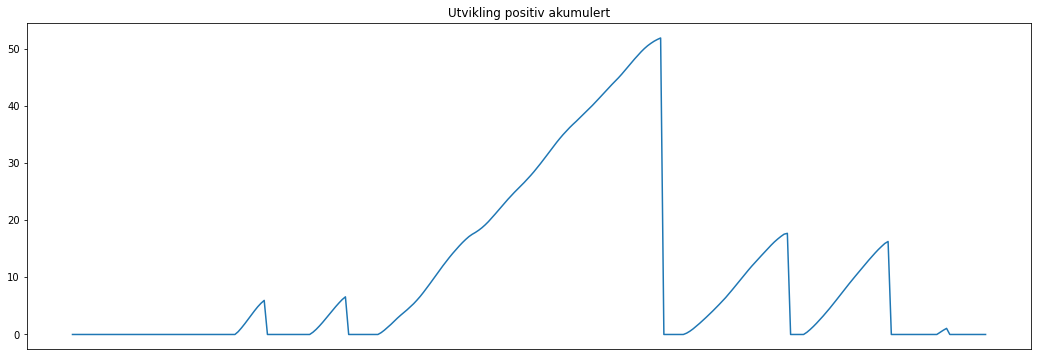

----------FERDIG---------


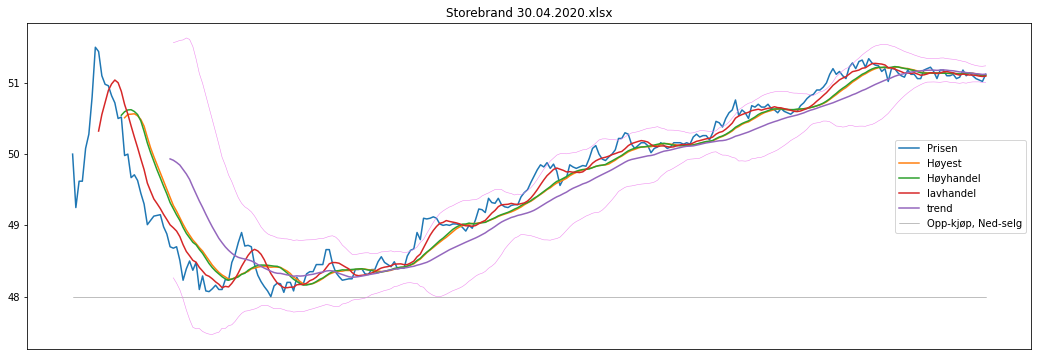

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


48 48


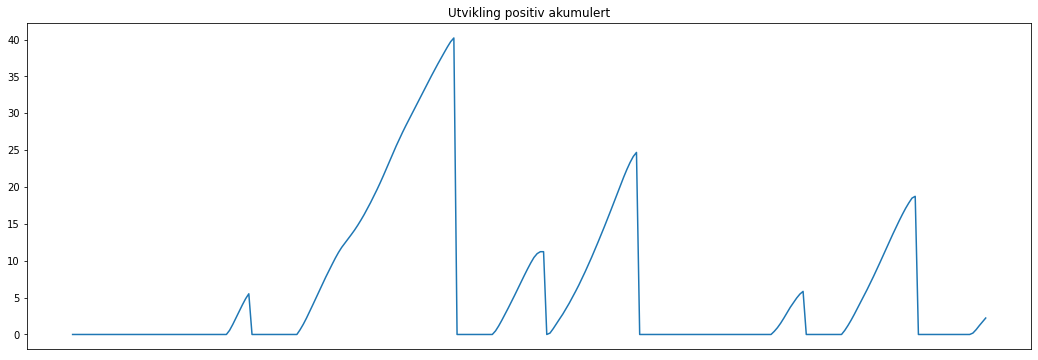

----------FERDIG---------


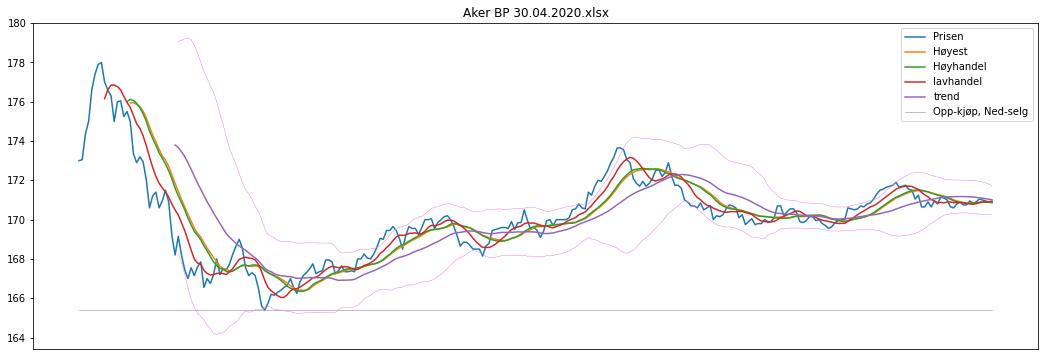

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


79 79


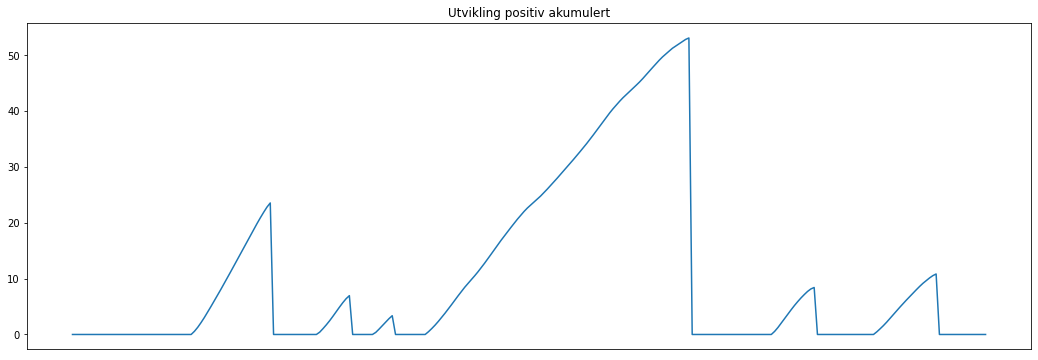

----------FERDIG---------


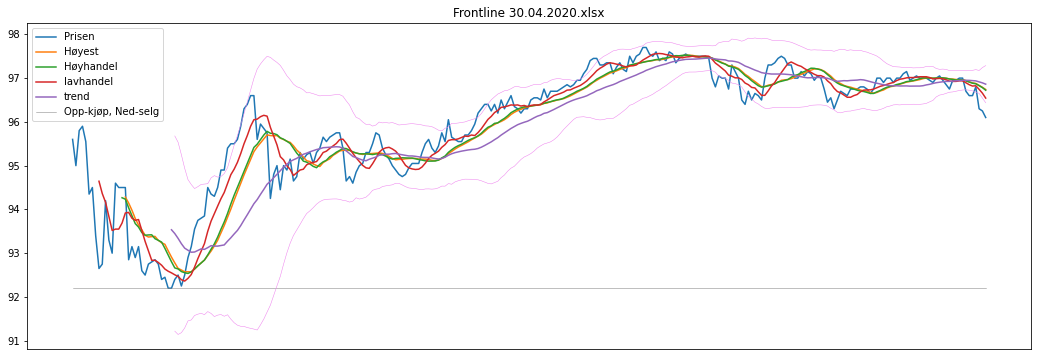

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


66 66


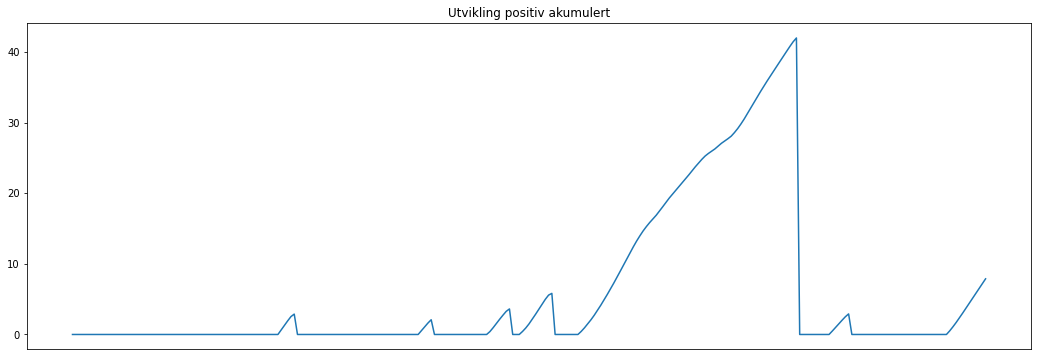

----------FERDIG---------


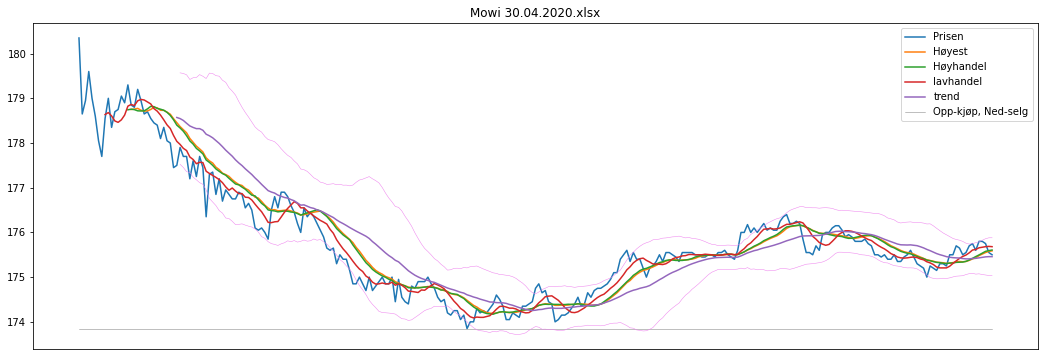

Antall handler: 0
(2500, 0)
0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


62 62


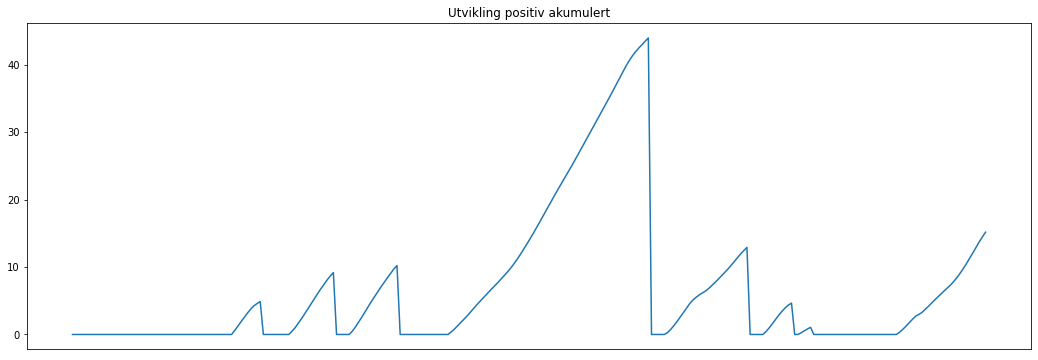

----------FERDIG---------


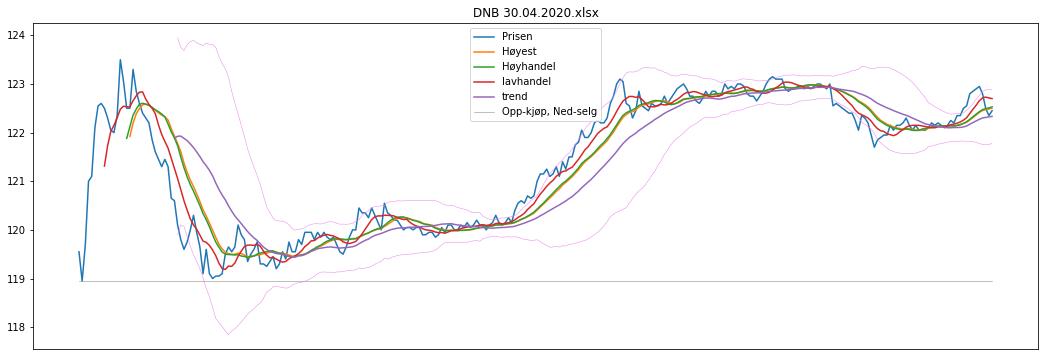

Antall handler: 0
(2500, 0)
0


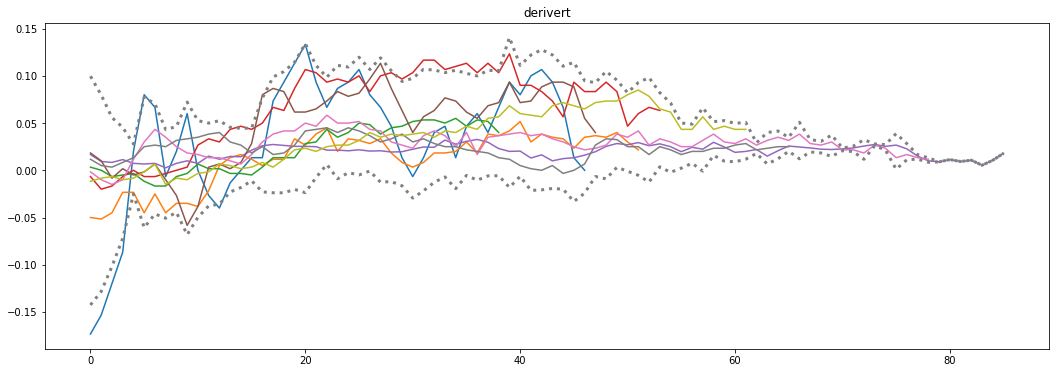

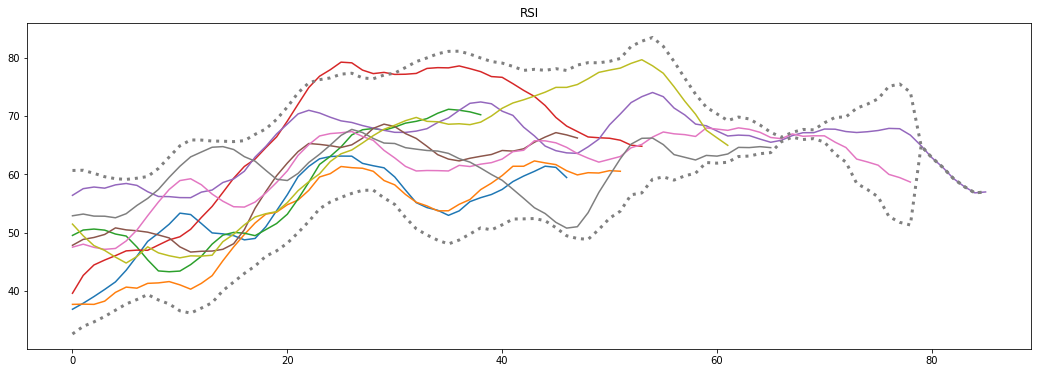

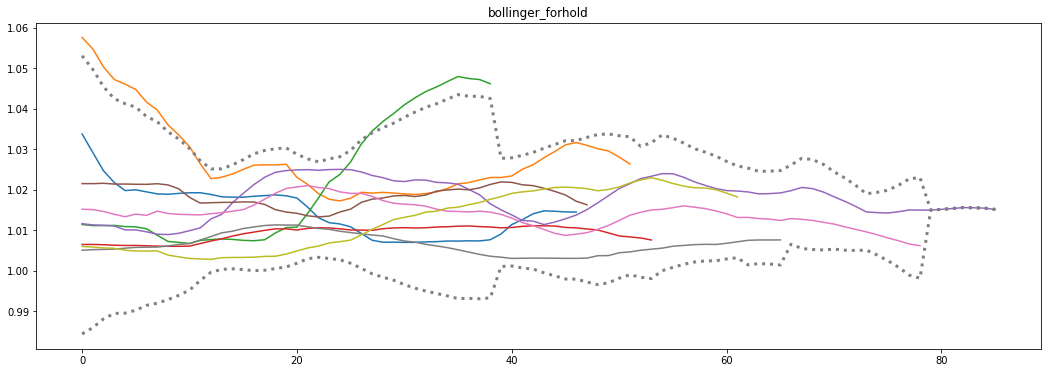

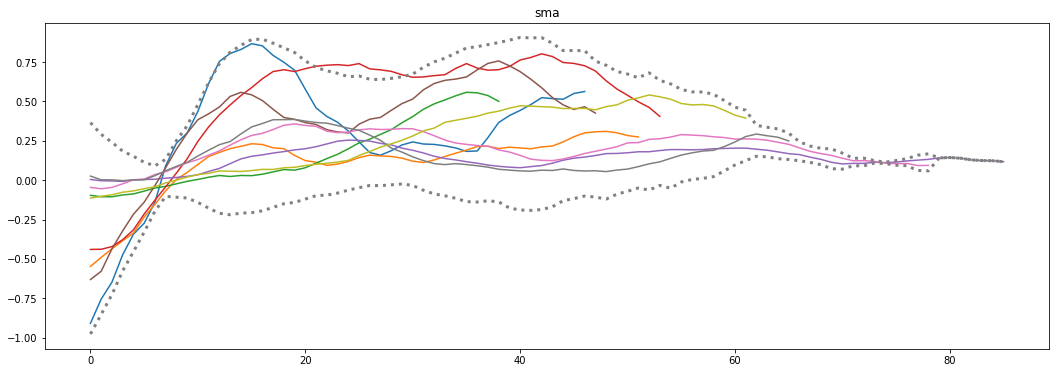

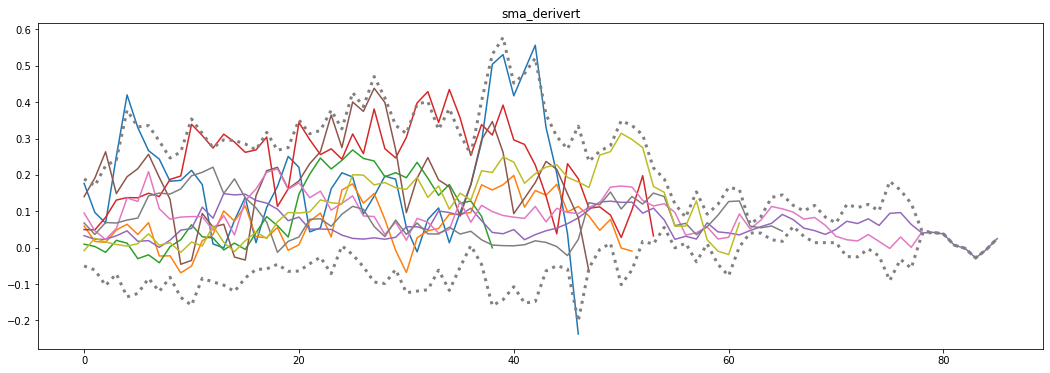

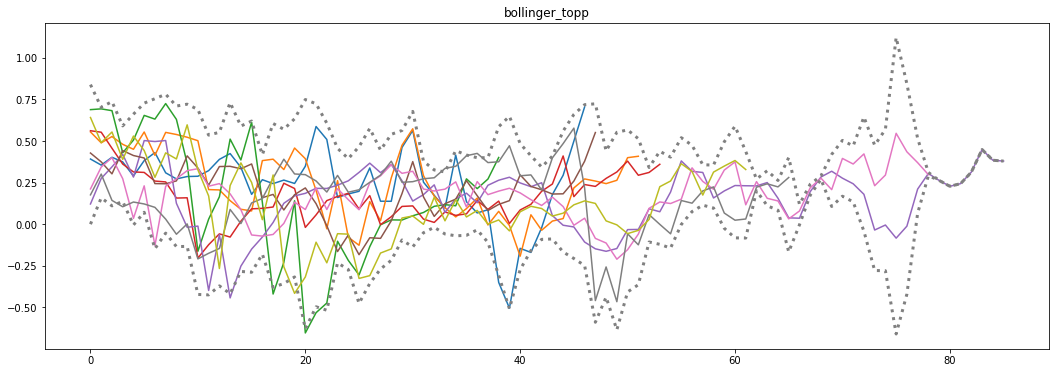

0
+: [] 
-: []


In [18]:
total = 0
plusses = []
minuses = []
start_df = pd.DataFrame(columns=['tid', 'indeks', 'endeks', 'Pris', 'score', 'derivert', 'RSI', 'bollinger_forhold', 'sma', 'sma_derivert', 'bollinger_topp'])

for i in range(0,len(list(uploaded.keys()))):
  df = dataframes[i]


  # Best so far 31.03 - i i-1 i/2 (i=16 scorer bra)
  sma16 = make_sma(df, 16)
  sma6 = make_sma(df, 15)
  sma_lav = make_sma(df, 8)

  underliggende_trend = make_sma(df, 30)
  derivert = make_derivert(df, underliggende_trend, 30)

  rsi = make_rsi(df, 30)
  adx = make_adx(df, underliggende_trend, 30)

  sma_bb = make_sma(df, 30)
  bollinger_band = make_bollinger_band(df, sma_bb, 30)

  # Ide: Tungt å kjøpe seg inn (høy handel), lett å kjøpe seg ut (lav handel )
  # 29.04 Ide: Kjøp - prisen har ikke steget til himmel i kjøps øyeblikket..
  #            Salg - Selg ved under 0.01% gevinst, behold dersom trend plutselig er positiv

  # modell_mean, modell_std
  handel = (handel_status(None, None, sma16, sma6, sma_lav, underliggende_trend, rsi, bollinger_band, derivert, df))
  start_df = start_df.append(handel[1], ignore_index=True)
  kjøp_og_selg_sma16_6 = handels_utførelse(handel[0], df)
  printing([sma16, sma6, sma_lav, underliggende_trend],
           ['Høyest', 'Høyhandel', 'lavhandel', 'trend'],
           handel[0],
           df,
           bollinger_band,
           list(uploaded.keys())[i])
  a = (simulering(kjøp_og_selg_sma16_6, df, print_handel=True))

  print(a)
  total += (a[0] - 2500)
  if(a[0]-2500 < 0):
    minuses.append(list(uploaded.keys())[i])
  elif(a[0]-2500 > 0):
    plusses.append(list(uploaded.keys())[i])
  print(total)



# her kan jeg lage std (modell)
# True - lage model, false - bruke modell
 
if(True):
  lengste = max([start_df['endeks'].iloc[i] - start_df['indeks'].iloc[i]  for i in range(len(start_df))])
  indikat = {'derivert':[[] for i in range(lengste)],
            'RSI':[[] for i in range(lengste)],
            'bollinger_forhold':[[] for i in range(lengste)],
            'sma':[[] for i in range(lengste)],
            'sma_derivert':[[] for i in range(lengste)],
            'bollinger_topp': [[] for i in range(lengste)]}

  for i in range(lengste):
    for j in range(len(start_df)):
      try:
        for o in indikat.keys():
          indikat[o][i].append(start_df[o].iloc[j][i])
        
      except:
        pass
  

  indikator = ['derivert', 'RSI', 'bollinger_forhold', 'sma', 'sma_derivert', 'bollinger_topp']
  modell_mean = {'derivert':[], 'RSI':[], 'bollinger_forhold':[], 'sma':[], 'sma_derivert':[], 'bollinger_topp':[]}
  modell_std = {'derivert':[], 'RSI':[], 'bollinger_forhold':[], 'sma':[], 'sma_derivert':[], 'bollinger_topp':[]}
  for j in range(len(indikator)):
    figure(figsize=(18,6))
    for i in range(len(start_df)):
      indeks = start_df['indeks'].iloc[i]
      endeks = start_df['endeks'].iloc[i]
      plt.plot(range(endeks - indeks), start_df[indikator[j]].iloc[i])

    mean = [statistics.mean(indikat[indikator[j]][i]) for i in range(len(indikat[indikator[j]]))]
    std = [statistics.stdev(indikat[indikator[j]][i]) if(len(indikat[indikator[j]][i])>1) else 0 for i in range(len(indikat[indikator[j]]))]

    plt.plot(range(len(mean)), [mean[i] + std[i]*2 for i in range(len(mean))], ':', color='grey', linewidth=3)
    plt.plot(range(len(mean)), [mean[i] - std[i]*2 for i in range(len(mean))], ':', color='grey', linewidth=3)

    modell_mean[indikator[j]] = mean
    modell_std[indikator[j]] = std

    plt.title(indikator[j])
    plt.show()

print(total)
print('+:',plusses,'\n-:',minuses)

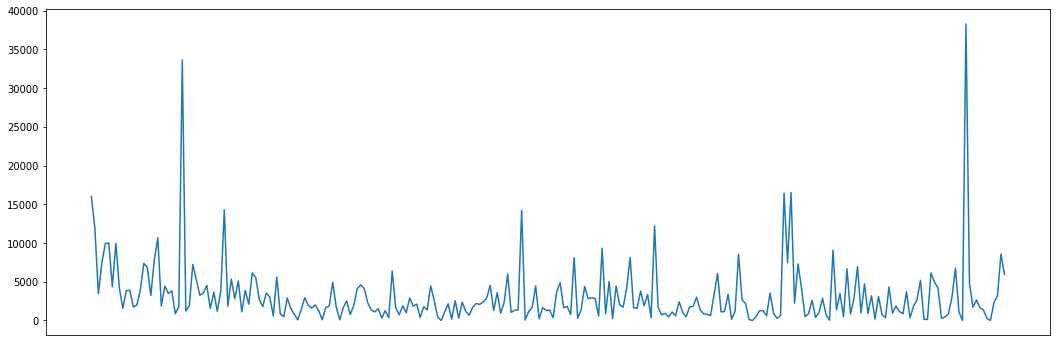

In [ ]:
indikator

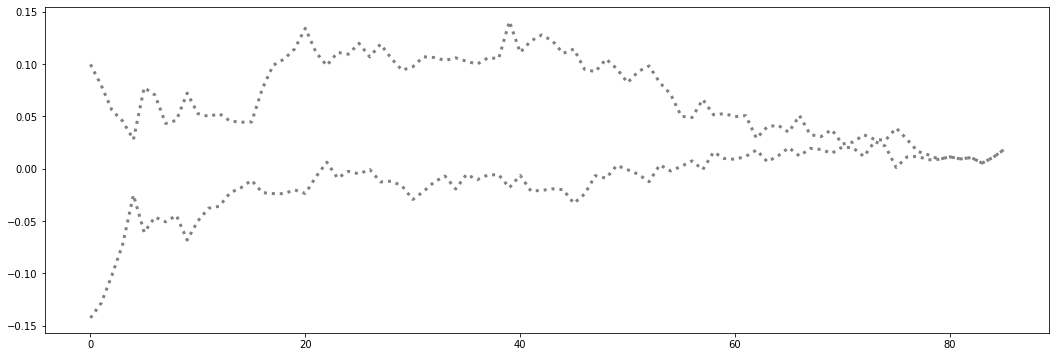

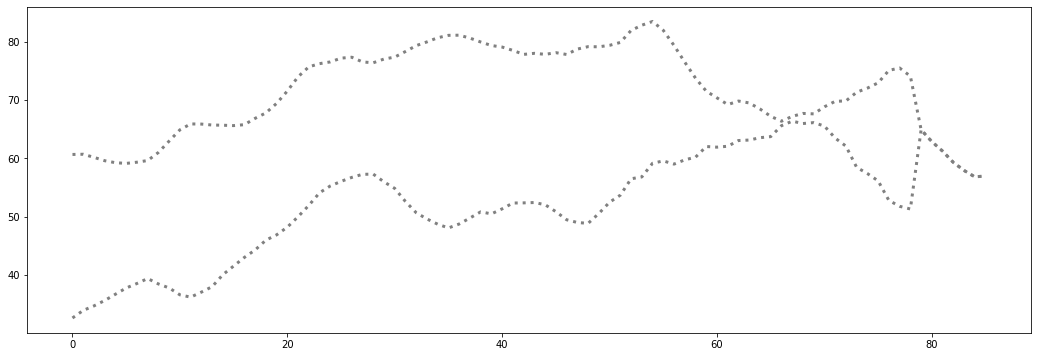

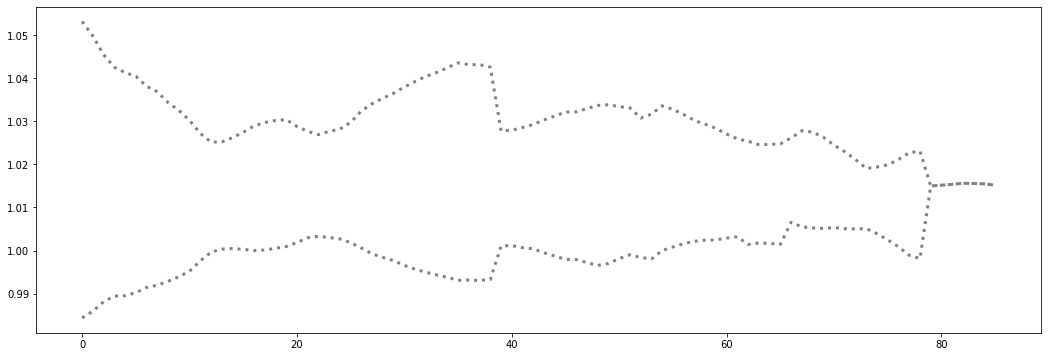

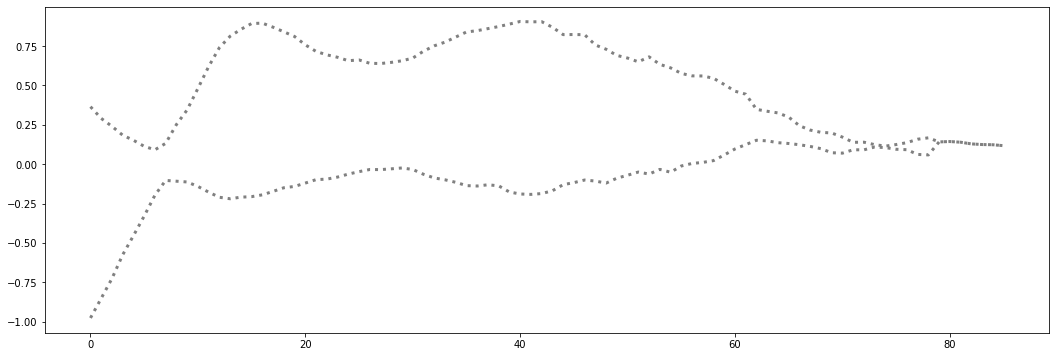

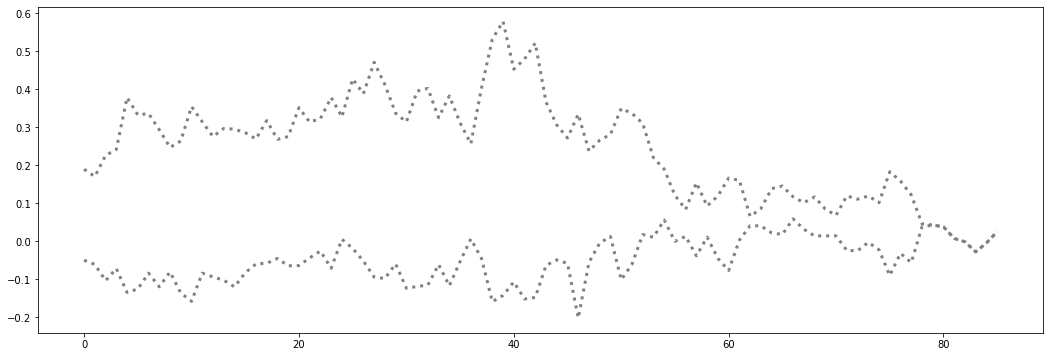

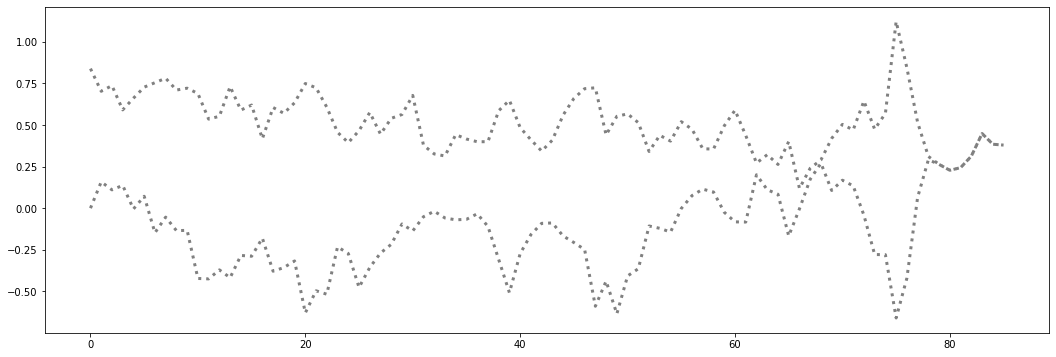

In [19]:
for j in range(len(indikator)):
  figure(figsize=(18,6))
  plt.plot(range(len(modell_mean[indikator[j]])), [modell_mean[indikator[j]][i] + modell_std[indikator[j]][i]*2 for i in range(len(mean))], ':', color='grey', linewidth=3)
  plt.plot(range(len(modell_mean[indikator[j]])), [modell_mean[indikator[j]][i] - modell_std[indikator[j]][i]*2 for i in range(len(mean))], ':', color='grey', linewidth=3)
